Read the output of the SHFQC using an oscillscope 

In [1]:
%matplotlib inline
import local_broom

Added 'quench/' and 'quench/libraries' for easy importing.


In [2]:
from laboneq.dsl.experiment import (
    #Section,
    Experiment,
    ExperimentSignal,
    #Sweep,
    pulse_library
)
from laboneq.dsl.device import DeviceSetup
from laboneq.dsl.session import Session
from laboneq.dsl.calibration import (
    Calibration,
    SignalCalibration,
    Oscillator
)

from laboneq.dsl.enums import (
    AcquisitionType,
    AveragingMode,
    SectionAlignment,
    PortMode,
    ModulationType
)

from laboneq.dsl import LinearSweepParameter  # SweepParameter

from laboneq.pulse_sheet_viewer.pulse_sheet_viewer import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

# plotting and fitting functionality
#from laboneq.analysis.fitting import (
    #lorentzian,
    #oscillatory,
    #oscillatory_decay,
#)

#from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

# for saving results and pulse sheets
from pathlib import Path
import time

import matplotlib.pyplot as plt
import numpy as np
from tqdm.autonotebook import tqdm

from monty import Monty

C:\Users\LD2007\AppData\Local\Temp\ipykernel_2588\621520450.py:44: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
experiment = {
    "desc": "Test the RF pulse code (AWG) is doing what i think it is."
}

monty = Monty("rf.awg tests", experiment)

Started new experiment rf.awg_tests


In [4]:
descriptor = """
instruments:
  SHFQC:
  - address: DEV12158
    uid: device_shfqc
    interface: 1gbe
    options: SHFQC/QC6CH  # added based on warning

connections:
  device_shfqc:
    - acquire_signal: set/acquire_line
      ports: [QACHANNELS/0/INPUT]
    - iq_signal: t1/drive_line
      ports: SGCHANNELS/4/OUTPUT  # 4 => labeled channel 5
    - iq_signal: t2/drive_line
      ports: SGCHANNELS/5/OUTPUT
"""


In [5]:
# Define and Load our Device Setup
device_setup = DeviceSetup.from_descriptor(
    yaml_text=descriptor,
    server_host="localhost",
    server_port="8004", 
    setup_name="my_setup",
)

session = Session(device_setup=device_setup)
session.connect(do_emulation=False)

[2024.06.25 14:32:21.155] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is C:\Users\LD2007\Documents\Si_CMOS_james\quench\june\laboneq_output\log
[2024.06.25 14:32:21.156] INFO    VERSION: laboneq 2.32.0
[2024.06.25 14:32:21.158] INFO    Connecting to data server at localhost:8004
[2024.06.25 14:32:21.342] INFO    Connected to Zurich Instruments LabOne Data Server version 24.04 at localhost:8004
[2024.06.25 14:32:25.042] INFO    Configuring the device setup
[2024.06.25 14:32:25.152] INFO    The device setup is configured


In [6]:
def compile_run(session, exp_name, exp, pulse_sheet=True):
    compiler_settings = {
        "OUTPUT_EXTRAS": True,
        "MAX_EVENTS_TO_PUBLISH": 1000,
    }
    compiled_exp = session.compile(exp, compiler_settings=compiler_settings)

    if pulse_sheet:
        root = Path("/Users/LD2007/Documents/Si_CMOS_james/pulse_sheets")
        root.mkdir(parents=True, exist_ok=True)
        path = root.joinpath(exp_name)
        #print(f"Saving pulse sheet to {path}")
        show_pulse_sheet(str(path), compiled_exp)
    #if exp_params["plot_simulation"] == 1:
    #plot_simulation(compiled_exp, start_time=exp_params["plt_start_time"], length=exp_params["plt_length"])

    return session.run(compiled_exp)



In [7]:
device_setup.logical_signal_groups["t1"].logical_signals["drive_line"].path

'/logical_signal_groups/t1/drive_line'

In [73]:
def simplepulse(exp_params):
    exp = Experiment(
        uid="simple",
        signals=[
            ExperimentSignal("t1", map_to='/logical_signal_groups/t1/drive_line'),
            ExperimentSignal("t2", map_to='/logical_signal_groups/t2/drive_line'),
            ExperimentSignal("acquire", map_to='/logical_signal_groups/set/acquire_line'),
        ],
    )

    with exp.acquire_loop_rt(
        uid=exp_params["exp_name"] + "_shots",
        count=exp_params["num_averages"],
        acquisition_type=AcquisitionType.SPECTROSCOPY,
        averaging_mode=AveragingMode.SEQUENTIAL):
        with exp.section(uid="spectroscopy"):
            exp.play(
                signal="t1",
                pulse=exp_params["dr_t1_pulse"],
                amplitude=exp_params["dr_t1_amp"],
                phase=180
            )
            exp.play(
                signal="t2",
                pulse=exp_params["dr_t2_pulse"],
                amplitude=exp_params["dr_t2_amp"],
                phase=180
            )
        #with exp.section(uid="relax", length=exp_params["delay"]):
        #    exp.reserve(signal="t1")
        #    exp.reserve(signal="t2")
                    
    cal = Calibration()
    cal["t1"] = SignalCalibration(
        local_oscillator = Oscillator(frequency = 0),
        oscillator=Oscillator(frequency=0, modulation_type=ModulationType.HARDWARE),
        amplitude=exp_params["t1_osc_gain"],
        range = exp_params["t1_pout_range"],
        port_mode=PortMode.LF,
    )
    cal["t2"] = SignalCalibration(
        local_oscillator = Oscillator(frequency = 0),
        oscillator=Oscillator(frequency=0, modulation_type=ModulationType.HARDWARE),
        amplitude=exp_params["t2_osc_gain"],
        range = exp_params["t2_pout_range"],
        port_mode=PortMode.LF,
    )

    cal["acquire"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=0),  # exp_params["ro_lo"]),
        port_mode=PortMode.LF,
        oscillator=Oscillator(frequency=400e6, modulation_type=ModulationType.HARDWARE),
        range=0)
    
    exp.set_calibration(cal)

    return exp
    

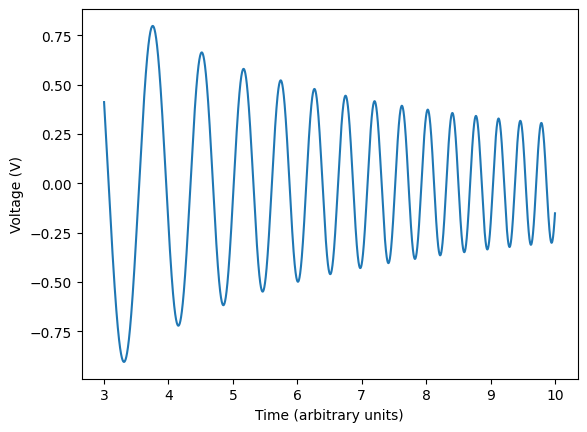

In [84]:
f = lambda x: 3*np.sin(x**2)/x
N = 40000
X = np.linspace(3, 10, N)
Y = f(X)

plt.plot(X, Y)
plt.xlabel("Time (arbitrary units)")
plt.ylabel("Voltage (V)")

spring = pulse_library.PulseSampled(uid="spring", samples=Y)

In [85]:
dr_pulse_len = 0.00001
dr_t1_pulse = pulse_library.const(uid = "dr_t1_pulse", amplitude = 1.0, length = dr_pulse_len, can_compress=True)
dr_t2_pulse = pulse_library.sawtooth(uid= "dr_t2_pulse", amplitude=1.0, length=dr_pulse_len, can_compress=True)

exp_params_simple = {
    "exp_name": "simple",
    "dr_t1_pulse": dr_t1_pulse,  # keep for triggering
    "dr_t2_pulse": spring,
    "dr_t1_amp": 1.0,
    "dr_t2_amp": 1.0,
    "delay": 0.00001,
    "num_averages": 5,
    "t1_osc_gain": 1.0,
    "t1_pout_range": 0,
    "t2_osc_gain": 1.0,
    "t2_pout_range": 0,
}

exp = simplepulse(exp_params_simple)
result = compile_run(session, exp_params_simple["exp_name"], exp)

[2024.06.25 15:41:30.006] INFO    Starting LabOne Q Compiler run...
[2024.06.25 15:41:30.012] INFO    Schedule completed. [0.002 s]
[2024.06.25 15:41:30.035] INFO    Code generation completed for all AWGs. [0.022 s]
[2024.06.25 15:41:30.036] INFO    Completed compilation step 1 of 1. [0.025 s]
[2024.06.25 15:41:30.041] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.06.25 15:41:30.042] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.06.25 15:41:30.042] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.06.25 15:41:30.043] INFO      device_shfqc        0          2            0           0         0  
[2024.06.25 15:41:30.044] INFO      device_shfqc_sg     4         11            1           1        64  
[2024.06.25 15:41:30.045] INFO      device_shfqc_sg     5          9            1           1     80000  
[2024.06.25 15:41:30.046] INFO     ──────────────────────────────────

## Apply arbitrary function as callback (feedback)